In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture as GMM
from matplotlib.patches import Ellipse
from sklearn.datasets import make_moons
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score



In [3]:
original_df = pd.read_csv(r'../../datasets/timeseries_dataset/timeseries_dataset.csv')
# original_df = original_df.loc[:, ~original_df.columns.isin(['id'])]
original_df.head()
original_df.shape

(14880, 6)

In [3]:
columns = list(original_df.columns)
n_samples, n_features = original_df.shape

In [4]:
synthetic_df = pd.read_csv(r'../../datasets/timeseries_dataset/synthetic.csv')
synthetic_df = synthetic_df[columns]
synthetic_df.head()

,Time,Open,High,Low,Close,Volume
0,1.455043e+09,1.114657,1.114469,1.114591,1.114875,2.261728e+08
1,1.454257e+09,1.084449,1.083999,1.083764,1.083197,-1.229986e+07
2,1.454773e+09,1.106810,1.105997,1.107730,1.104799,-1.092781e+07
3,1.453602e+09,1.080069,1.079876,1.078143,1.079582,1.247860e+08
4,1.455342e+09,1.120671,1.120474,1.119948,1.120266,3.089058e+07


In [5]:
from sklearn.preprocessing import LabelEncoder


predictors = {'categorical': [],
             'continuous': ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']}


def to_numpy(df, columns):
    """
    Convert dataframe to numpy array by converting categorical variables as integer labels
    :param df: The dataframe to convert
    :param columns: The continuous & discrete columns
    :return: Converted numpy arrays of X & Y and the label encoders
    """
    # Fetch the columns from the dataframe
    _columns = list(df.columns)

    # declaring empty arrays for the predictor and target variables
    X = np.empty(df[_columns].shape)

    # Assign the values from the columns, that are declared continuous,
    # into the corresponding positions in the numpy array
    for i, col in enumerate(columns['continuous']):
        X[:, _columns.index(col)] = df[col]

    # Encoding for X (predictors)
    for i, col in enumerate(columns['categorical']):
        # Initialize, fit and store the label encoder for column
        enc = LabelEncoder()
        enc.fit(df[col])

        # Transform the column using the encoder object
        X[:, _columns.index(col)] = enc.transform(df[col])

    return X


original_X = to_numpy(original_df, predictors)
synthetic_X = to_numpy(synthetic_df, predictors)

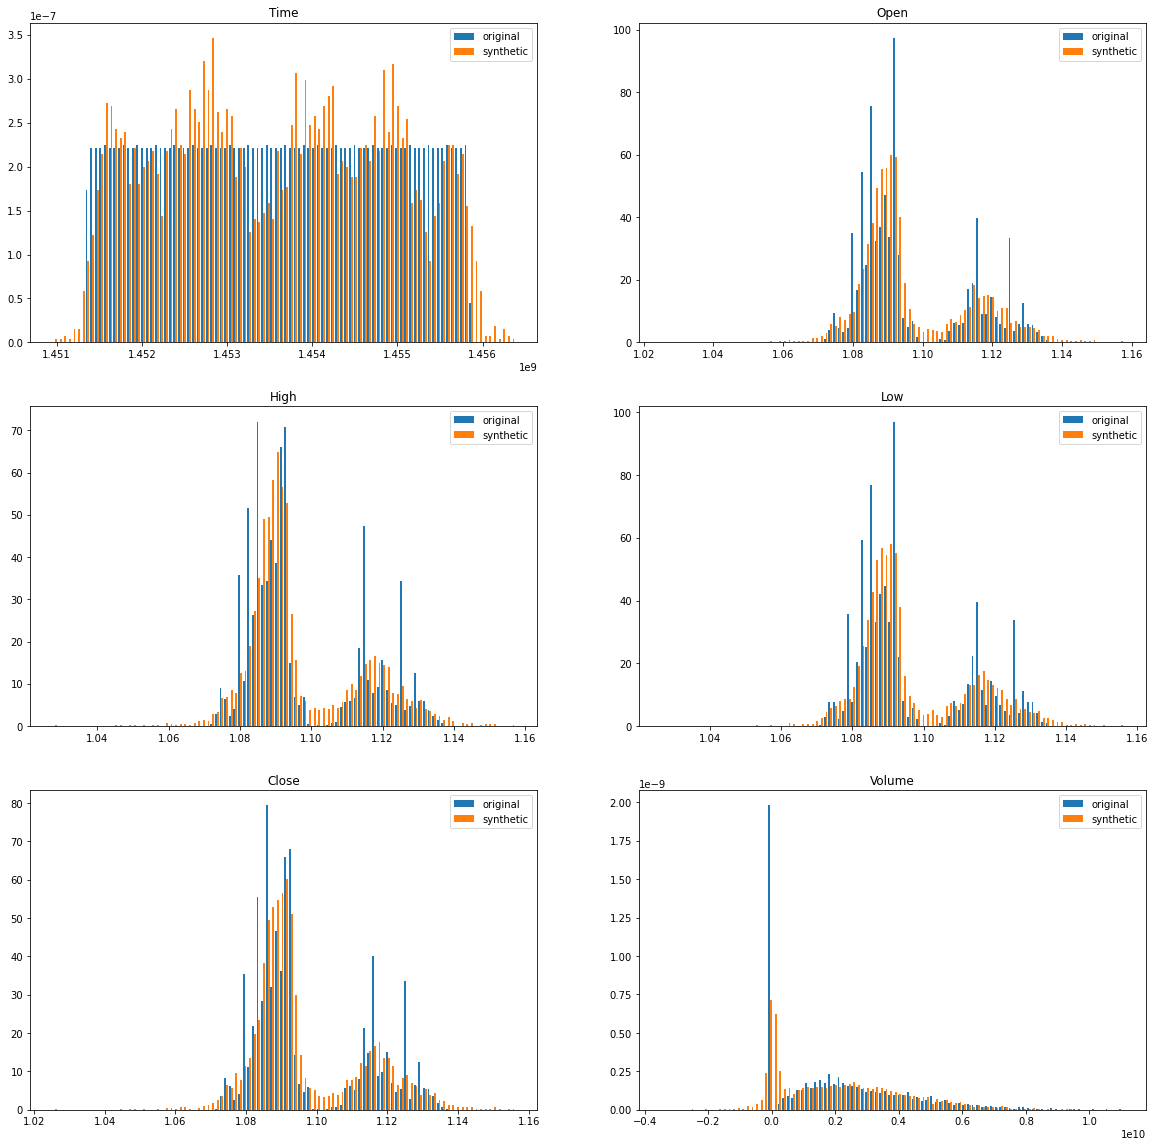

In [6]:
# plotting the distribution of the features using histogram

fig_rows = int(n_features/2) if n_features % 2 == 0 else int(n_features/2 + 1)
fig_columns = 2
bins = 100

fig,ax = plt.subplots(fig_rows, fig_columns, figsize=(20,20))
for i, feature in enumerate(range(n_features)):
    row_num = int(feature/fig_columns)
    col_num = feature%fig_columns
    if len(ax.shape) > 1:
        ax[row_num, col_num].hist([original_X[:, feature], synthetic_X[:, feature]],
                                  bins=bins, density=True,
                                  label=['original', 'synthetic'])
        ax[row_num, col_num].legend(['original', 'synthetic'])
        ax[row_num, col_num].title.set_text(f"{list(original_df.columns)[i]}")

    else:
        ax[col_num].hist([X[:, feature], Xn[0][:, feature]],
                         bins=bins, density=True,
                         label=['original', 'synthetic'])
        ax[col_num].legend(['original', 'synthetic'])
        ax[col_num].title.set_text(f"{list(original_df.columns)[i]}")



In [7]:
from scipy.stats import chisquare, ks_2samp, epps_singleton_2samp


categorical = ["Gender", "Age", "Driving_License", "Region_Code",
               "Previously_Insured", "Vehicle_Age", "Vehicle_Damage",
               "Policy_Sales_Channel", "Vintage", "Response"]
continuous = ["Annual_Premium"]
print(list(original_df.columns))


def get_probabilities(df, col):
    probs = []
    n = len(df[col])
    vals = sorted(list(df[col].unique()))
    cat_counts = df[col].value_counts()
    for cat in vals:
        probs.append(cat_counts[cat]/n)
    return vals, probs



for i, feature in enumerate(range(n_features)):
    column = columns[i]
    if column in categorical:
        unobserved = [i for i in list(original_df[column].unique()) if i not in list(synthetic_df[column].unique())]
        o_vals, o_probs = get_probabilities(original_df, column)
        s_vals, s_probs = get_probabilities(synthetic_df, column)
        for j in unobserved:
            s_probs.insert(o_vals.index(j), 0)
        pvalue = chisquare(f_obs=s_probs, f_exp=o_probs).pvalue
        print(f"p-value for col {column}: {pvalue}")
    else:
        n1 = original_X[:, i].shape[0]
        n2 = synthetic_X[:, i].shape[0]
        
        data1 = original_X[:, i]
        data2 = synthetic_X[:, i]
        data_all = np.concatenate([data1, data2])
        cdf1 = np.searchsorted(data1, data_all, side='right') / n1
        cdf2 = np.searchsorted(data2, data_all, side='right') / n2
        cddiffs = cdf1 - cdf2
        # Ensure sign of minS is not negative.
        minS = np.clip(-np.min(cddiffs), 0, 1)
        maxS = np.max(cddiffs)
        pvalue = max(minS, maxS)
        
        print(f"p-value for col {column}: {pvalue}")
    

['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
p-value for col Time: 0.683
p-value for col Open: 0.7012
p-value for col High: 0.7010000000000001
p-value for col Low: 0.7264
p-value for col Close: 0.7562
p-value for col Volume: 0.8098


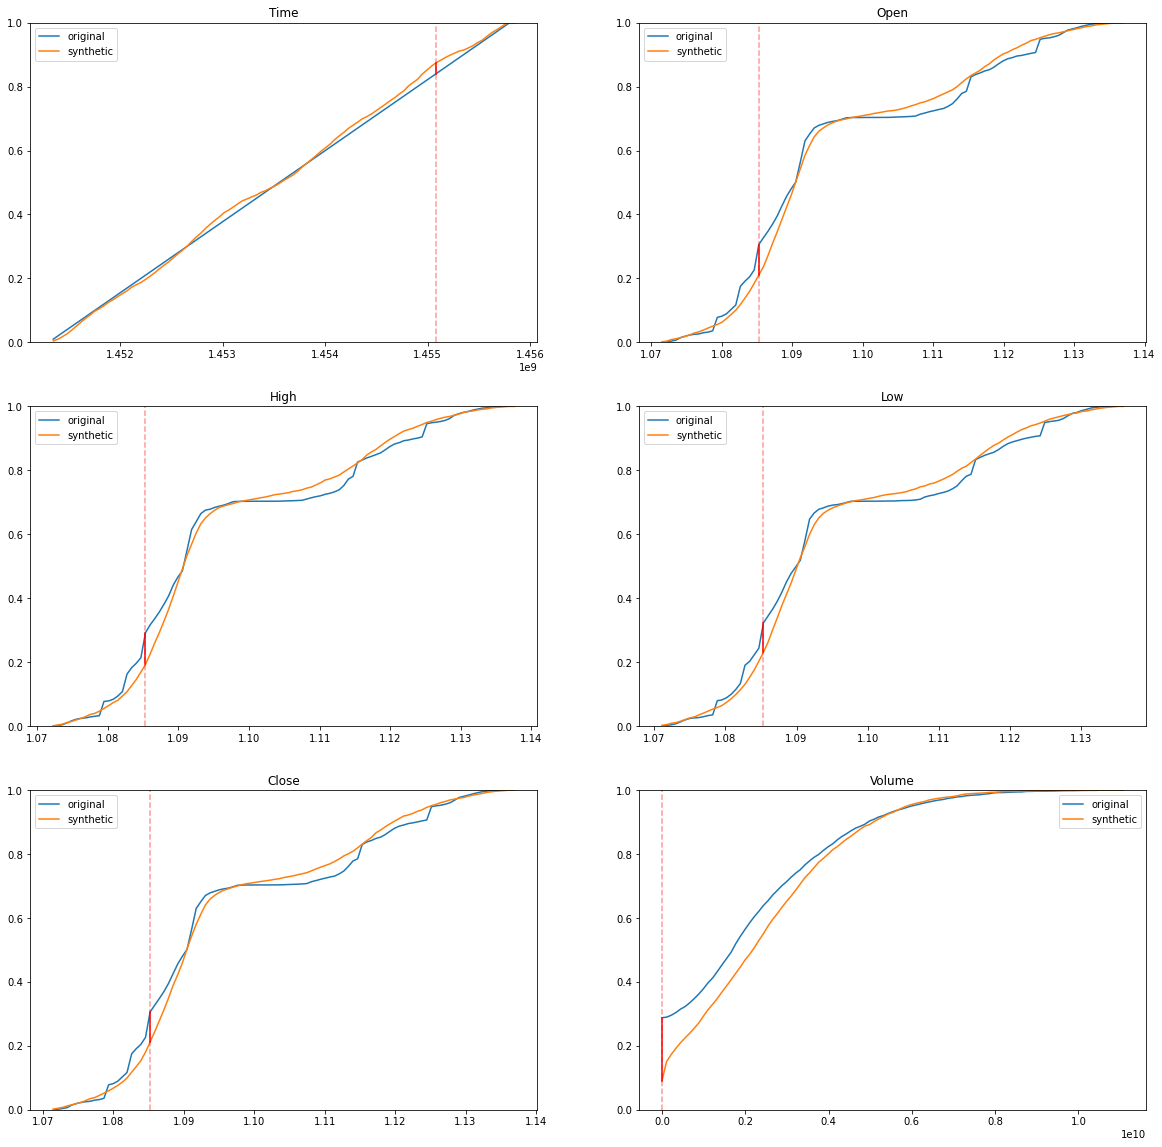

In [8]:
fig_rows = int(n_features/2) if n_features % 2 == 0 else int(n_features/2 + 1)
fig_columns = 2

fig,ax = plt.subplots(fig_rows, fig_columns, figsize=(20,20))

for i, feature in enumerate(range(n_features)):
    row_num = int(feature/fig_columns)
    col_num = feature%fig_columns
    
#     o_rand = np.random.choice(original_X[:, i], 200)
#     s_rand = np.random.choice(synthetic_X[:, i], 200)
    o_rand = original_X[:, i]
    s_rand = synthetic_X[:, i]
    
    o_hist, o_bin_edges = np.histogram(o_rand, bins=bins, density=True)
    o_scaled_hist = o_hist/sum(o_hist)
    o_cum_hist = list(np.cumsum(o_scaled_hist))
    o_cum_hist.append(1.0)
    
    s_hist, s_bin_edges = np.histogram(s_rand, bins=o_bin_edges, density=True)
    s_scaled_hist = s_hist/sum(s_hist)
    s_cum_hist = list(np.cumsum(s_scaled_hist))
    s_cum_hist.append(1.0)
    
    y = np.arange(1.0, len(o_bin_edges) + 1)/len(o_bin_edges)
    yc = np.interp(o_cum_hist, s_cum_hist, o_bin_edges)
    ind_max = np.argmax(np.subtract(o_cum_hist, s_cum_hist) ** 2)

    if len(ax.shape) > 1:
        ax[row_num, col_num].plot(o_bin_edges, o_cum_hist)
        ax[row_num, col_num].plot(s_bin_edges, s_cum_hist)
        ax[row_num, col_num].axvline(o_bin_edges[ind_max], color="red", linestyle="dashed", alpha=0.4)
        ax[row_num, col_num].plot([o_bin_edges[ind_max], o_bin_edges[ind_max]], [o_cum_hist[ind_max], s_cum_hist[ind_max]], color="red")
        ax[row_num, col_num].legend(['original', 'synthetic'])
        ax[row_num, col_num].title.set_text(f"{list(original_df.columns)[i]}")
        ax[row_num, col_num].set_ylim([0.0, 1.0])

    else:
        ax[row_num, col_num].plot(o_bin_edges, o_cum_hist)
        ax[row_num, col_num].plot(s_bin_edges, s_cum_hist)
        ax[row_num, col_num].axvline(o_bin_edges[ind_max], color="red", linestyle="dashed", alpha=0.4)
        ax[row_num, col_num].plot([o_bin_edges[ind_max], o_bin_edges[ind_max]], [o_cum_hist[ind_max], s_cum_hist[ind_max]], color="red")
        ax[col_num].legend(['original', 'synthetic'])
        ax[col_num].title.set_text(f"{list(original_df.columns)[i]}")
        ax[row_num, col_num].set_ylim([0.0, 1.0])

    